# Plot the APO model

Plot the modelled $\delta$ APO model, as well as the components

In [1]:
import os, glob
import xarray as xr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta

from acrg.name import name
from acrg.obs import get_obs
from acrg.convert import concentration

plt.style.use('tableau-colorblind10')

# sys.path.append(os.environ['FUNCS'])
import apo_emiss_func, apo_filter, apo_plot_info, apo_funcs

In [2]:
year = 2015
months = [mm for mm in range(1, 13)] # [8, 12] #
sites = ['WAO', 'HFD', 'RGL'] #
ocean_sims = ['ECCO', 'Jena', 'NEMO']
poster = False #True

save = False

months = [months] if type(months)==int else months

start_dates = {month: datetime(year, month, 1) for month in months}
end_dates = {month: start_date + relativedelta(months=1, seconds=-1) for month, start_date in start_dates.items()}

nrows = len(months) * len(sites)

sites = {site: code for site, code in apo_plot_info.sitecodes.items() if site in sites}

date_str = f'{year}' if months==[mm for mm in range(1, 13)] else \
           f'{year}{str(months[0]).zfill(2)}-{str(months[-1]).zfill(2)}' if len(months)>2 else \
           f'{year}{str(months[0]).zfill(2)}-{year}{str(months[-1]).zfill(2)}' if len(months)==2 else None

print(date_str)

2015


### Get the timeseries data

Import the pre-run forward models

In [4]:
ts_data_year = apo_funcs.get_timeseries(sites=sites.keys(), year=year, sources=['ff', 'ocean', 'bc'])
ts_data_all = {site: {month: ts_site.sel(time=slice(start, end_dates[month]))
                      for month, start in start_dates.items()}
               for site, ts_site in ts_data_year.items()}

species_labels = {source: f'{source.split("_")[0]} FF' if 'ff' in source else
                          f'{source.split("_")[0]} ocean, {[apo_plot_info.model_names[ss.lower()] for ss in ocean_sims if ss.lower() in source][0]}'
                          if 'ocean' in source else None
                  for source in ts_data_all[list(sites.keys())[0]][months[0]].data_vars}

Finding timeseries for WAO
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2015.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2015.nc']
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2015.nc']

Data variables:
['co2_ff', 'o2_ff', 'o2_ocean_nemo', 'n2_ocean_nemo', 'o2_ocean_ecco', 'o2_ocean_jena', 'co2_ocean_nemo', 'apo_bc', 'co2_bc', 'o2_bc']
Finding timeseries for HFD
ff: ['/user/work/vf20487/Timeseries/o2_co2/HFD_ff_timeseries_2015.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/HFD_ocean_timeseries_2015.nc']
bc: ['/user/work/vf20487/Timeseries/o2_co2/HFD_bc_timeseries_2015.nc']

Data variables:
['co2_ff', 'o2_ff', 'o2_ocean_nemo', 'n2_ocean_nemo', 'o2_ocean_ecco', 'o2_ocean_jena', 'co2_ocean_nemo', 'apo_bc', 'co2_bc', 'o2_bc']
Finding timeseries for RGL
ff: ['/user/work/vf20487/Timeseries/o2_co2/RGL_ff_timeseries_2015.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/RGL_ocean_timeseries_2015.nc']
bc: ['/user/work/vf20487/Time

### Calculate APO

Calculate the APO contribution from each species

In [5]:
apo_species = {site: {month: apo_emiss_func.apo_species_split(ocean_co2 = ts_month.co2_ocean_nemo,
                                                              ocean_n2 = ts_month.n2_ocean_nemo,
                                                              ocean_o2 = ts_month.o2_ocean_ecco,
                                                              ff_co2 = ts_month.co2_ff,
                                                              ff_o2 = ts_month.o2_ff)
                   for month, ts_month in ts_site.items()}
            for site, ts_site in ts_data_all.items()}

for site, ts_site in ts_data_all.items():
        for month, ts_month in ts_site.items():
                apo_species[site][month] = {'o2_ocean_ecco' if k == 'o2_ocean' else k:v for k,v in apo_species[site][month].items()}
                for sim in ['jena', 'nemo']:
                        apo_species[site][month][f'o2_ocean_{sim}'] = apo_emiss_func.apo_species_split(ocean_o2 = ts_month[f'o2_ocean_{sim}'])['o2_ocean']

### Calculate average contributions

Get the average contribution to APO from the ocean and fossil fuel O2 fluxes

In [6]:
contributions = {site: {month: {sim: np.median(ts_month[f'o2_ocean_{sim}'].values)
                                for sim in ['ecco', 'jena', 'nemo']}
                        for month, ts_month in ts_site.items()}
                for site, ts_site in ts_data_all.items()}
print('Ocean contributions')
print_contribution = [[print(f'{site}, {apo_plot_info.month_names[month]}:    ECCO: {cont_month["ecco"]:.3f};    ' +
                             f'Jena: {cont_month["jena"]:.3f};    NEMO: {cont_month["nemo"]:.3f}')
                       for month, cont_month in cont_site.items()]
                      for site, cont_site in contributions.items()]

contributions_ff = {site: {month: np.mean(ts_month['o2_ff'].values)
                           for month, ts_month in ts_site.items()}
                    for site, ts_site in ts_data_all.items()}
print('O2 ff contributions')
print_contribution = [[print(f'{site}, {apo_plot_info.month_names[month]}: {cont_month:.3f}')
                       for month, cont_month in cont_site.items()]
                      for site, cont_site in contributions_ff.items()]

Ocean contributions
WAO, Jan:    ECCO: -1.448;    Jena: -1.059;    NEMO: -0.936
WAO, Feb:    ECCO: -1.529;    Jena: -1.302;    NEMO: -1.182
WAO, Mar:    ECCO: -0.847;    Jena: -0.812;    NEMO: -0.560
WAO, Apr:    ECCO: 0.093;    Jena: 0.282;    NEMO: -0.005
WAO, May:    ECCO: 1.120;    Jena: 0.612;    NEMO: 1.041
WAO, Jun:    ECCO: 2.070;    Jena: 1.271;    NEMO: 2.797
WAO, Jul:    ECCO: 1.272;    Jena: 0.230;    NEMO: 2.205
WAO, Aug:    ECCO: 0.685;    Jena: 0.046;    NEMO: 1.137
WAO, Sep:    ECCO: 0.460;    Jena: -0.291;    NEMO: 0.269
WAO, Oct:    ECCO: -0.138;    Jena: -0.200;    NEMO: -0.423
WAO, Nov:    ECCO: -0.328;    Jena: -1.254;    NEMO: -0.655
WAO, Dec:    ECCO: -0.606;    Jena: -1.609;    NEMO: -0.857
HFD, Jan:    ECCO: -1.335;    Jena: -1.049;    NEMO: -0.962
HFD, Feb:    ECCO: -1.597;    Jena: -1.178;    NEMO: -1.136
HFD, Mar:    ECCO: -0.807;    Jena: -0.849;    NEMO: -0.547
HFD, Apr:    ECCO: 0.152;    Jena: 0.131;    NEMO: 0.309
HFD, May:    ECCO: 1.274;    Jena: 0.55

## Plot the components

First calculate the ocean and ff components and define APO labels

In [7]:
apo_split = {site: {month: {ocean_sim.split("_")[-1]: apo_month['co2_ocean'] + apo_o2 + apo_month['n2_ocean']
                            for ocean_sim, apo_o2 in apo_month.items() if ocean_sim[:8]=='o2_ocean'}
                    for month, apo_month in apo_site.items()}
             for site, apo_site in apo_species.items()}
for site, apo_site in apo_species.items():
    for month, apo_month in apo_site.items():
        apo_split[site][month]['ff'] = apo_month['co2_ff']

apo_labels = {source: 'FF' if source=='ff' else f'ocean, {[apo_plot_info.model_names[ss.lower()] for ss in ocean_sims if ss.lower()==source][0]}'
              for source in apo_split[list(sites.keys())[0]][months[0]].keys()}
apo_labels

{'ecco': 'ocean, ECCO',
 'jena': 'ocean, Jena',
 'nemo': 'ocean, NEMO-ERSEM',
 'ff': 'FF'}

Now plot the components

Saving to /user/work/vf20487/Figures/APO_timeseries/APO_timeseries_speciesAPO_WAO-HFD-RGL_201508-201512.png


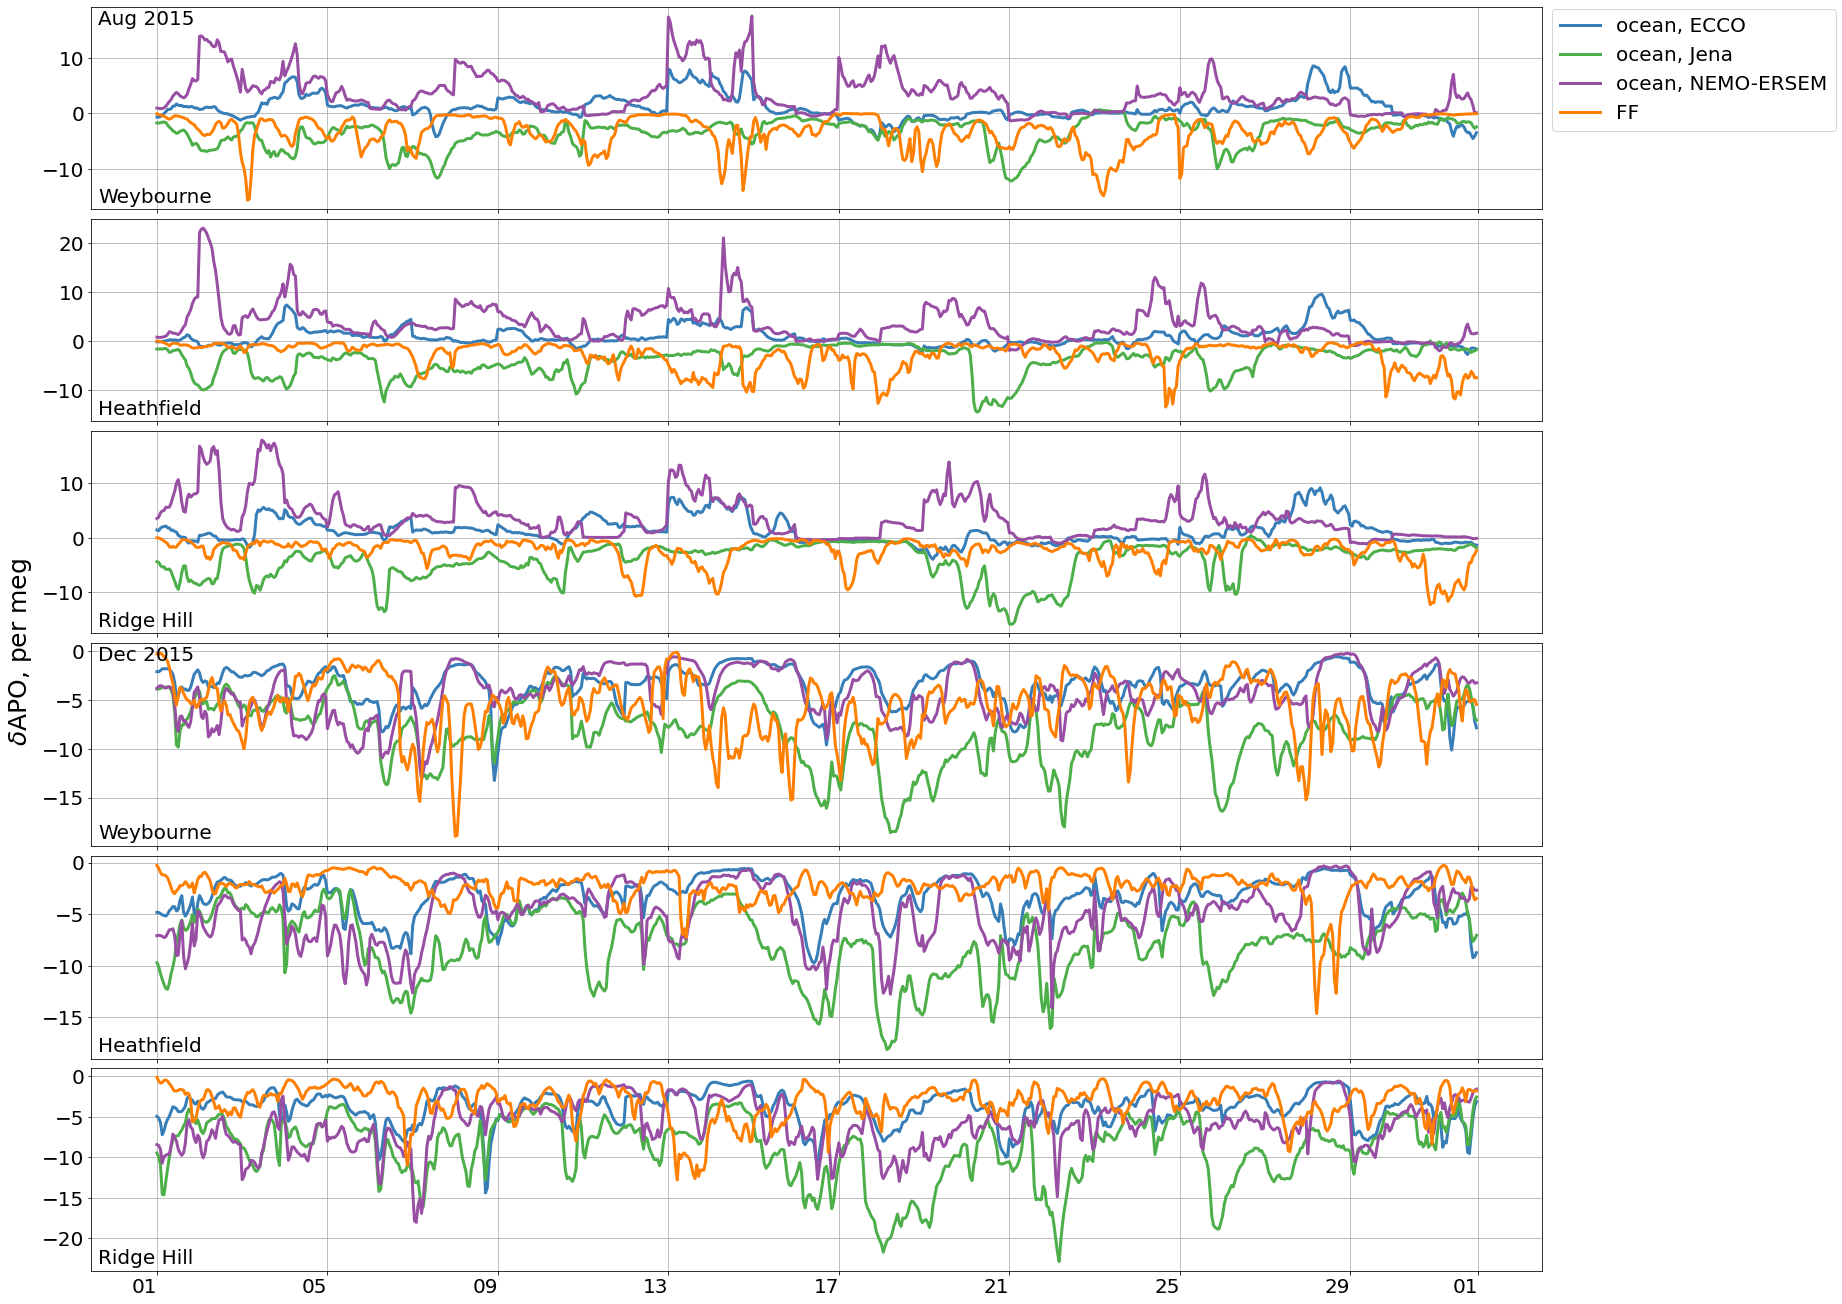

In [14]:
fig, axes = plt.subplots(nrows=len(sites)*len(months), ncols=1, figsize=(25, 3*len(sites)*len(months)), constrained_layout=True)
lines = {site: {month: [apo_month[var.lower()].plot(ax=axes[ss+len(sites)*mm], color=apo_plot_info.colors[var], label=f'{label}', lw=3)
                        for var, label in apo_labels.items()]
                for mm, (month, apo_month) in enumerate(apo_site.items())}
         for ss, (site, apo_site) in enumerate(apo_split.items())}

legend = axes[0].legend(bbox_to_anchor=(1,1.04), fontsize=20)
xlabel = [ax.set_xlabel('') for ax in axes]
ylabel = [ax.set_ylabel('') for ax in axes]
ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)

myFmt = mdates.DateFormatter('%d')
[ax.xaxis.set_major_formatter(myFmt) for ax in axes]
ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
ticks = [axes[ii].xaxis.set_ticklabels([]) for ii in range(len(axes)) if ii!=len(sites)*len(months)-1]
text = {month: axes[len(sites)*mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[len(sites)*mm].transAxes, va='top', fontsize=20)
        for mm, month in enumerate(months)}
grid = [ax.grid() for ax in axes]

if poster:
        text = axes[-1].text(1.01, 0.7, r'Fig. 3:', transform=axes[-1].transAxes, va='top', fontsize=20)
        text = axes[-1].text(1.01, 0.55, r'Modelled contribution' + '\nfrom the ocean and fossil' +
                             '\nfuel components to $\delta$APO' + '\nat Weybourne during' + '\nAug and Dec 2014.',
                             transform=axes[-1].transAxes, va='top', fontsize=20)

if len(sites)>1:
   sites_text = list(sites.values())*len(months)
   [ax.text(0.005, 0.015, sites_text[aa], va='bottom', transform=ax.transAxes, fontsize=20) for aa, ax in enumerate(axes)]
   
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                        f'APO_timeseries_speciesAPO_{"-".join(sites)}_{date_str}.png')
print(f'Saving to {filename}')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

Saving to /user/work/vf20487/Figures/APO_timeseries/APO_timeseries_species_WAO-HFD-RGL_201508.png
Saving to /user/work/vf20487/Figures/APO_timeseries/APO_timeseries_species_WAO-HFD-RGL_201512.png


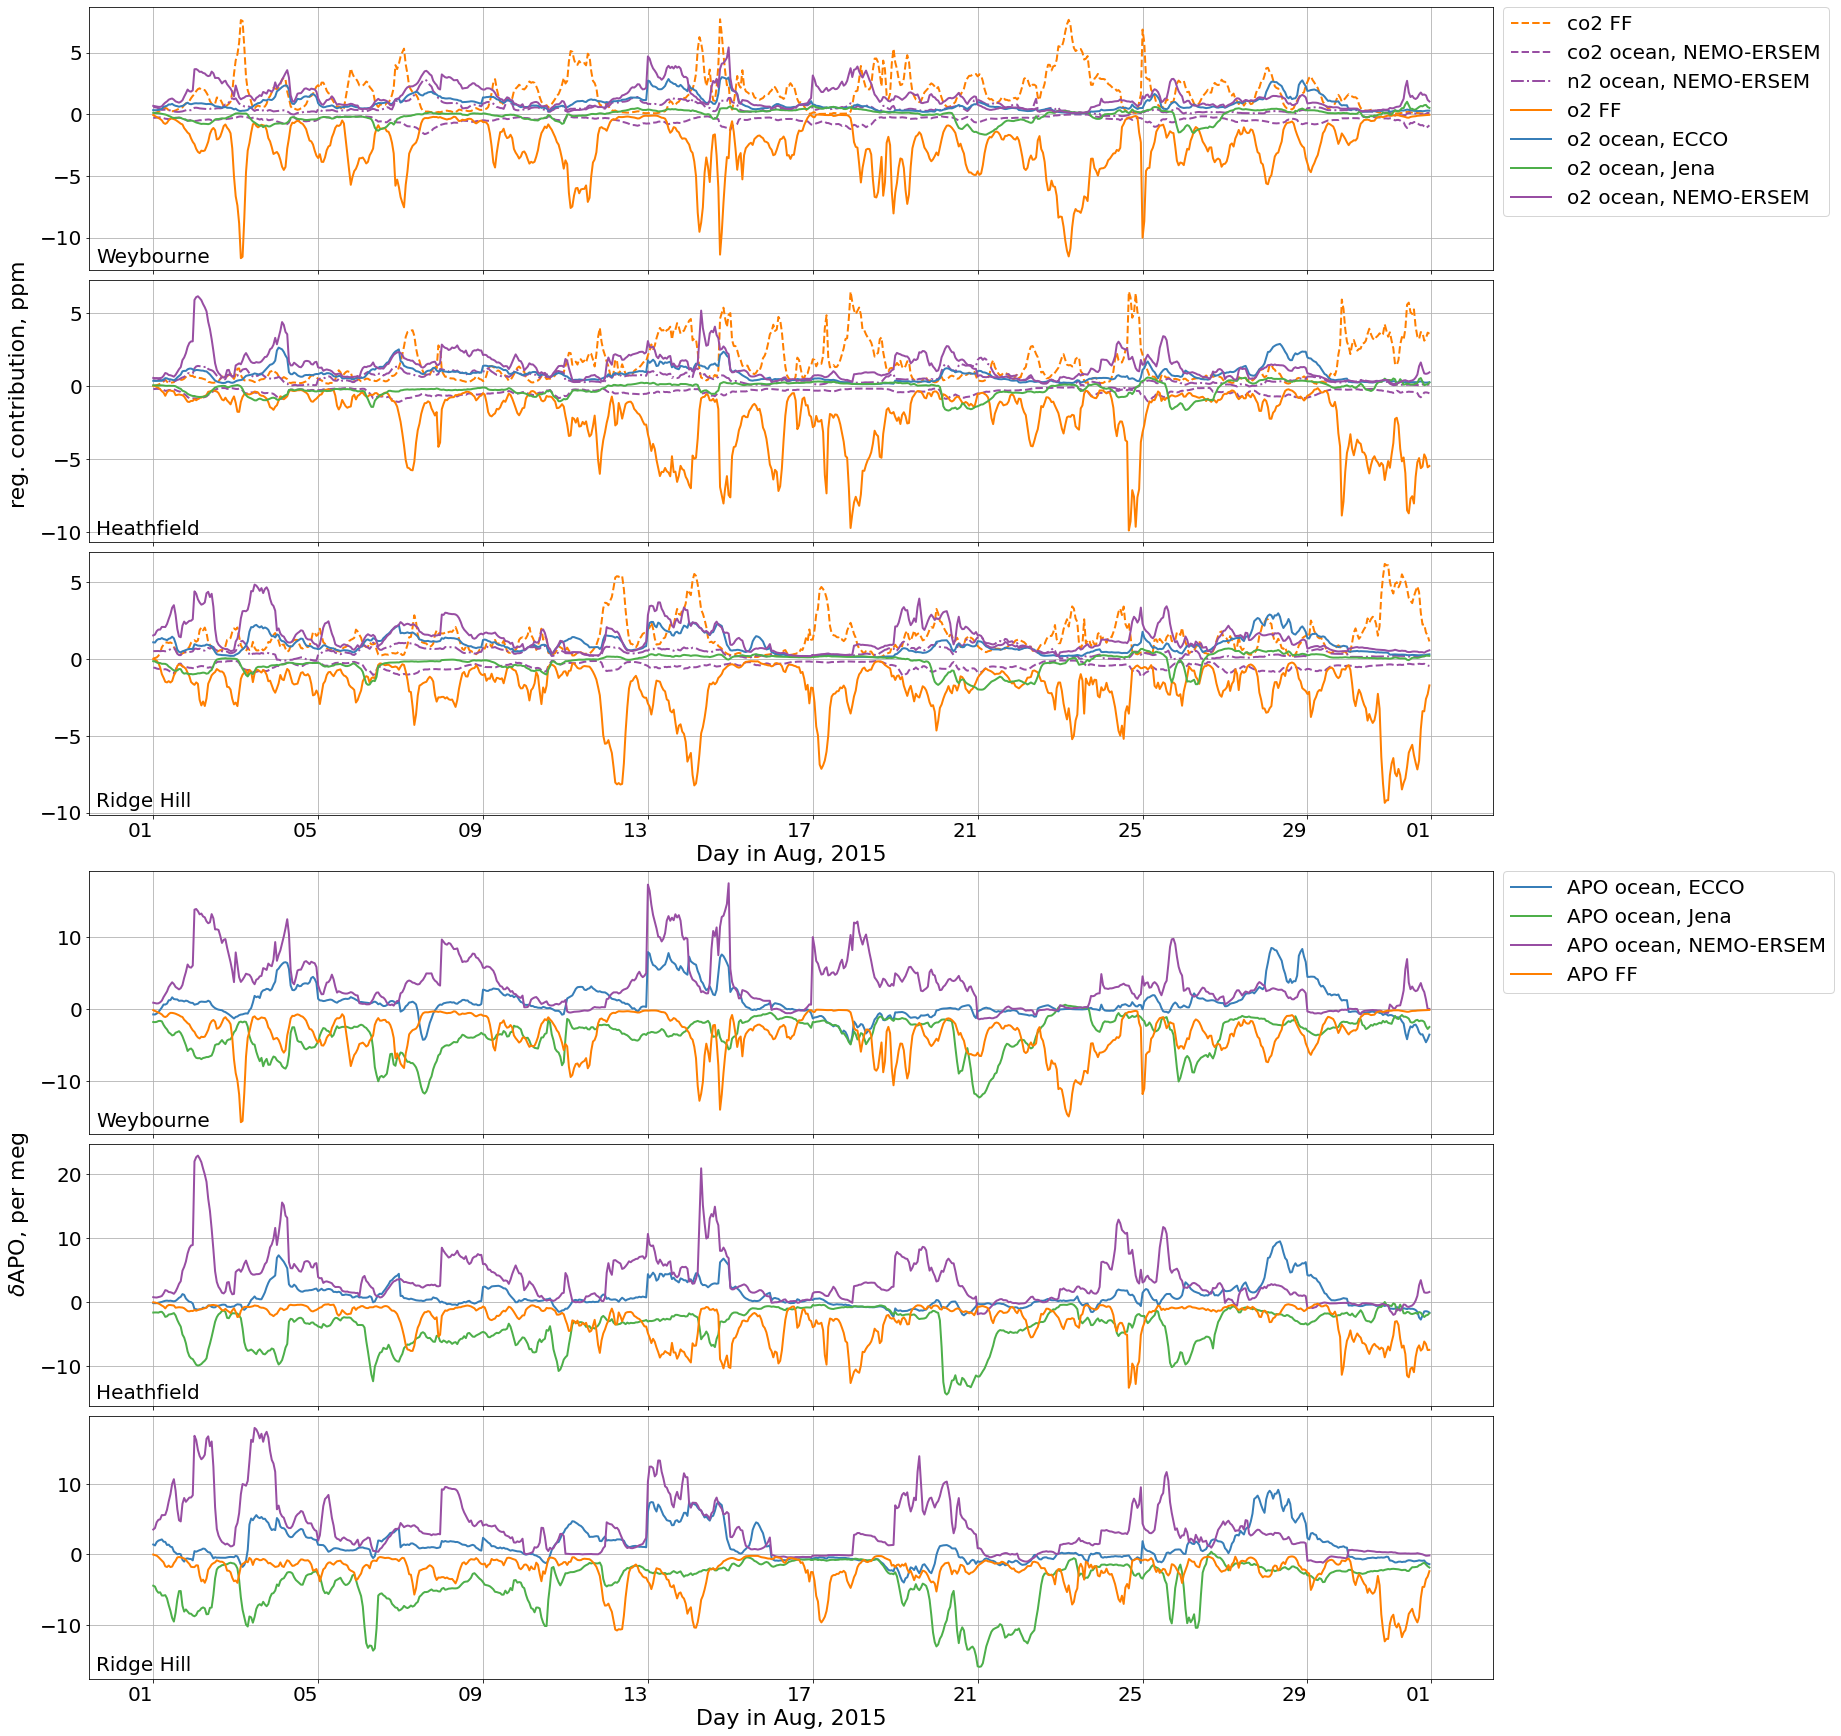

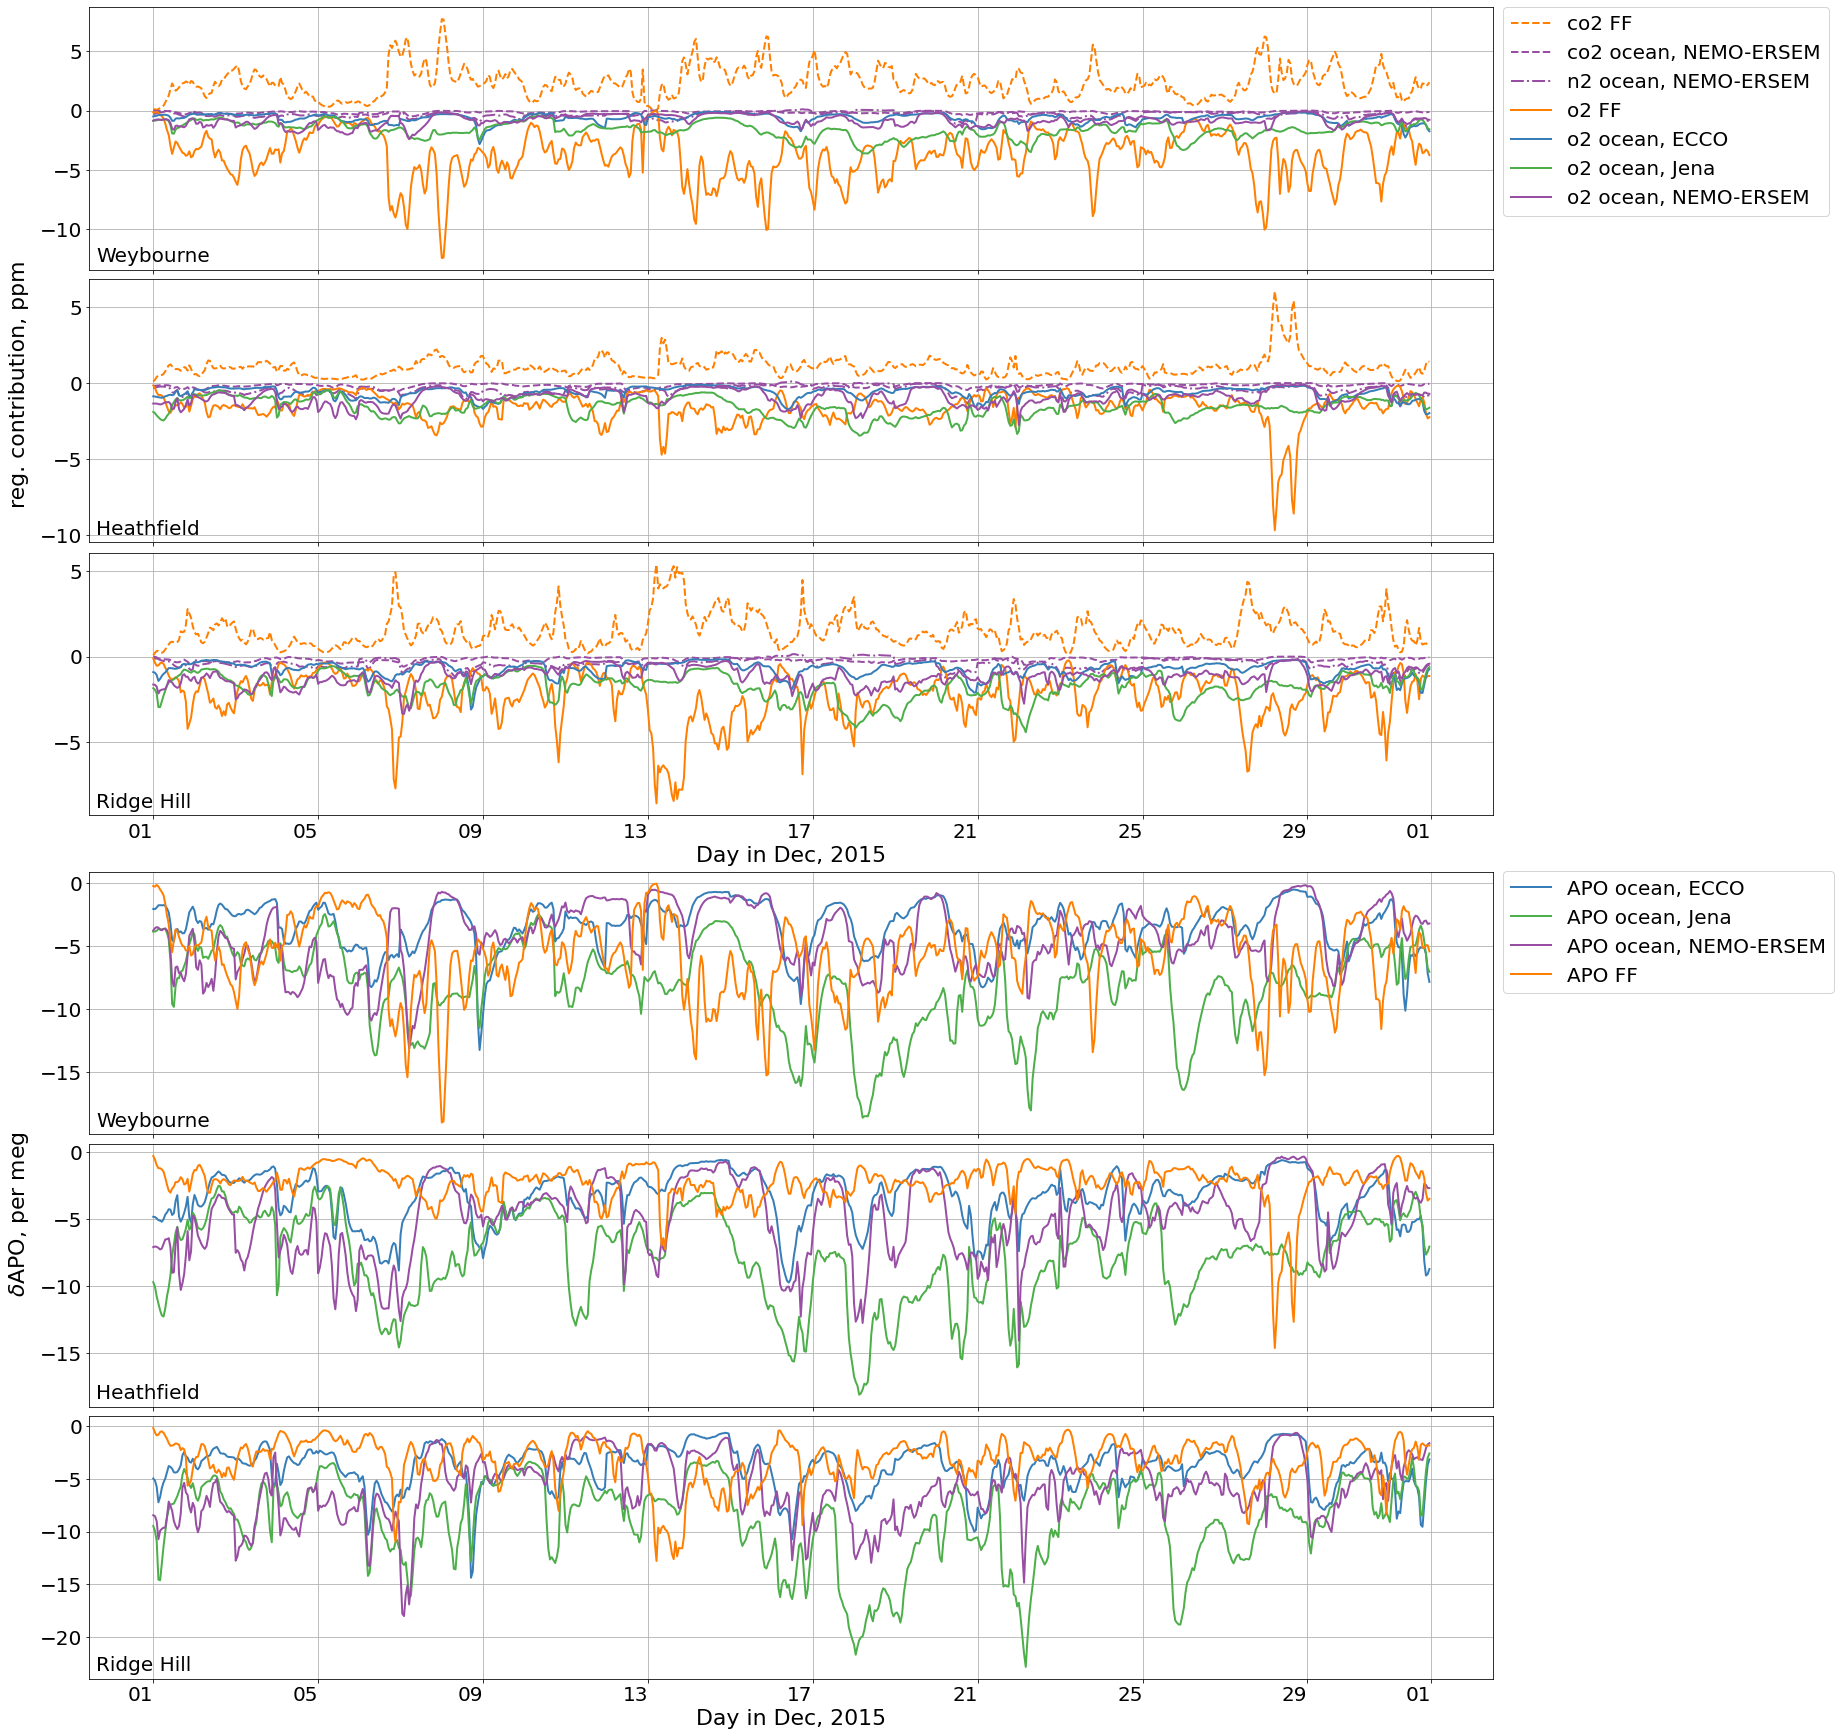

In [22]:
for month in months:
   fig, axes = plt.subplots(nrows=2*len(sites), ncols=1, figsize=(25, 4*2*len(sites)), constrained_layout=True)
   lines = {site: [ts_site[month][var].plot(ax=axes[ss], label=species_labels[var], ls=apo_plot_info.ls[var.split('_')[0]],
                                            color=apo_plot_info.colors_sources[var.split('2_')[1].lower()], lw=2)
                   for vv, var in enumerate(sorted(ts_site[month].data_vars)) if all([ss not in var for ss in ['diff', 'unc',  'bc']])]
            for ss, (site, ts_site) in enumerate(ts_data_all.items())}

   lines = {site: [apo_site[month][var.lower()].plot(ax=axes[len(sites)+ss], color=apo_plot_info.colors[var],
                                                     label=f'APO {label}', lw=2)
                   for var, label in apo_labels.items()]
            for ss, (site, apo_site) in enumerate(apo_split.items())}

   legend = [axes[ii].legend(bbox_to_anchor=(1,1.04), fontsize=20) for ii in [0, len(sites)]]
   myFmt = mdates.DateFormatter('%d')
   [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
   ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
   xlabel = [ax.set_xlabel('') for ax in axes]
   # add an xlabel to show the month to one axis for each plot type
   if len(sites)==1:
      xlabel = axes[1].set_xlabel(f'Day in {apo_plot_info.month_names[month]}, {year}', fontsize=22)
      ticks = axes[0].xaxis.set_ticklabels([])
   else:
      xlabel = [axes[ii*len(sites)+2].set_xlabel(f'Day in {apo_plot_info.month_names[month]}, {year}', fontsize=22)
               for ii in range(2)]
      ticks = [axes[ii].xaxis.set_ticklabels([]) for ii in range(len(axes)) if ii not in [jj*len(sites)+2 for jj in range(2)]]
   ylabel = [ax.set_ylabel('') for ax in axes]
   ylabel = fig.text(-0.01, 0.78, 'reg. contribution, ppm', va='center', ha='center', rotation='vertical', fontsize=22)
   ylabel = fig.text(-0.01, 0.3, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=22)
   # ylabel = axes[0].set_ylabel('regional contribution, ppm', fontsize=22)
   # ylabel = axes[1].set_ylabel('regional contribution, per meg', fontsize=22)
   # text = axes[0].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[0].transAxes, va='top', fontsize=20)
   grid = [ax.grid() for ax in axes]

   if len(sites)>1:
      sites_text = list(sites.values())*2
      [ax.text(0.005, 0.015, sites_text[aa], va='bottom', transform=ax.transAxes, fontsize=20) for aa, ax in enumerate(axes)]
   
   filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                           f'APO_timeseries_species_{"-".join(sites)}_{year}{str(month).zfill(2)}.png')
   print(f'Saving to {filename}')
   fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

### Calculate the total APO

In [8]:
apo_model = {site: {month: {sim: apo_emiss_func.apo(ocean_co2 = ts_month.co2_ocean_nemo,
                                                    ocean_n2 = ts_month.n2_ocean_nemo,
                                                    ocean_o2 = ts_month[f'o2_ocean_{sim.lower()}'],
                                                    ff_co2 = ts_month.co2_ff,
                                                    ff_o2 = ts_month.o2_ff) + ts_month.apo_bc - apo_plot_info.adjust[year][month]
                            for sim in ocean_sims if sim not in ['ff', 'land', 'obs']}
                    for month, ts_month in ts_site.items()}
             for site, ts_site in ts_data_all.items()}

In [9]:
apo_model_year = {}
for site, apo_site in apo_model.items():
    apo_model_year[site] = {}
    for key, value in apo_site.items():
        for k, v in value.items():
            if k not in apo_model_year[site].keys():
                apo_model_year[site][k] = {}
            apo_model_year[site][k][key] = v
    for model, apo_mod in apo_model_year[site].items():
        apo_model_year[site][model] = xr.concat(list(apo_mod.values()), dim='time')

### Compare the models

- get the differences between the models
- get the correlation betwee models

In [10]:
max_diff = {month: np.max([(apo_month['NEMO'].mean() - apo_month['ECCO'].mean()),  
                           (apo_month['NEMO'].mean() - apo_month['Jena'].mean()),
                           (apo_month['Jena'].mean() - apo_month['ECCO'].mean())])
            for month, apo_month in apo_model['WAO'].items()}

print('--- Maximum average difference between APO models ---')
print_diffs = [print(f'{apo_plot_info.month_names[month]}: {diff_month:.3f}')
               for month, diff_month in max_diff.items()]

--- Maximum average difference between APO models ---
Jan: 2.367
Feb: 2.424
Mar: 1.843
Apr: 1.001
May: 4.818
Jun: 9.863
Jul: 11.026
Aug: 6.979
Sep: 3.223
Oct: -0.350
Nov: 3.758
Dec: 3.762


In [11]:
rmse_models = {site: {month: {'ecco-jena': (((apo_month['ECCO'] - apo_month['Jena'])**2).mean().values)**0.5,
                              'ecco-nemo': (((apo_month['ECCO'] - apo_month['NEMO'])**2).mean().values)**0.5,
                              'jena-nemo': (((apo_month['Jena'] - apo_month['NEMO'])**2).mean().values)**0.5,}
               for month, apo_month in apo_site.items()}
        for site, apo_site in apo_model.items()}

print('--- RMSE between APO models ---')
print_diffs = [[print(f'{site}, {apo_plot_info.month_names[month]}:    ecco-jena: {rmse_month["ecco-jena"]:.3f};    ' +
                      f'ecco-nemo: {rmse_month["ecco-nemo"]:.3f};    nemo-jena: {rmse_month["jena-nemo"]:.3f}')
                for month, rmse_month in rmse_site.items()]
               for site, rmse_site in rmse_models.items()]

--- RMSE between APO models ---
WAO, Jan:    ecco-jena: 4.944;    ecco-nemo: 3.650;    nemo-jena: 4.070
WAO, Feb:    ecco-jena: 4.758;    ecco-nemo: 4.256;    nemo-jena: 3.092
WAO, Mar:    ecco-jena: 4.095;    ecco-nemo: 3.357;    nemo-jena: 3.495
WAO, Apr:    ecco-jena: 4.179;    ecco-nemo: 5.520;    nemo-jena: 6.900
WAO, May:    ecco-jena: 4.388;    ecco-nemo: 7.531;    nemo-jena: 9.645
WAO, Jun:    ecco-jena: 6.419;    ecco-nemo: 13.602;    nemo-jena: 15.424
WAO, Jul:    ecco-jena: 6.696;    ecco-nemo: 8.531;    nemo-jena: 13.355
WAO, Aug:    ecco-jena: 5.631;    ecco-nemo: 4.451;    nemo-jena: 8.407
WAO, Sep:    ecco-jena: 4.464;    ecco-nemo: 2.935;    nemo-jena: 4.390
WAO, Oct:    ecco-jena: 1.549;    ecco-nemo: 2.093;    nemo-jena: 2.612
WAO, Nov:    ecco-jena: 5.918;    ecco-nemo: 2.640;    nemo-jena: 5.614
WAO, Dec:    ecco-jena: 5.651;    ecco-nemo: 2.400;    nemo-jena: 5.094
HFD, Jan:    ecco-jena: 5.627;    ecco-nemo: 3.678;    nemo-jena: 4.487
HFD, Feb:    ecco-jena: 5.236

In [12]:
correlations_models = {site: {month: {'ecco-jena': xr.corr(apo_month['ECCO'], apo_month['Jena']).values**2,
                                      'ecco-nemo': xr.corr(apo_month['ECCO'], apo_month['NEMO']).values**2,
                                      'jena-nemo': xr.corr(apo_month['Jena'], apo_month['NEMO']).values**2,}
                       for month, apo_month in apo_site.items()}
                for site, apo_site in apo_model.items()}

print('--- Correlation between APO models ---')
print_diffs = [[print(f'{site}, {apo_plot_info.month_names[month]}:    ecco-jena: {corr_month["ecco-jena"]:.3f};    ' +
                      f'ecco-nemo: {corr_month["ecco-nemo"]:.3f};    nemo-jena: {corr_month["jena-nemo"]:.3f}')
                for month, corr_month in corr_site.items()]
               for site, corr_site in correlations_models.items()]

--- Correlation between APO models ---
WAO, Jan:    ecco-jena: 0.592;    ecco-nemo: 0.866;    nemo-jena: 0.683
WAO, Feb:    ecco-jena: 0.682;    ecco-nemo: 0.810;    nemo-jena: 0.819
WAO, Mar:    ecco-jena: 0.674;    ecco-nemo: 0.814;    nemo-jena: 0.746
WAO, Apr:    ecco-jena: 0.653;    ecco-nemo: 0.593;    nemo-jena: 0.342
WAO, May:    ecco-jena: 0.776;    ecco-nemo: 0.338;    nemo-jena: 0.201
WAO, Jun:    ecco-jena: 0.576;    ecco-nemo: 0.089;    nemo-jena: 0.129
WAO, Jul:    ecco-jena: 0.282;    ecco-nemo: 0.237;    nemo-jena: 0.025
WAO, Aug:    ecco-jena: 0.435;    ecco-nemo: 0.471;    nemo-jena: 0.257
WAO, Sep:    ecco-jena: 0.792;    ecco-nemo: 0.712;    nemo-jena: 0.698
WAO, Oct:    ecco-jena: 0.960;    ecco-nemo: 0.944;    nemo-jena: 0.890
WAO, Nov:    ecco-jena: 0.735;    ecco-nemo: 0.836;    nemo-jena: 0.679
WAO, Dec:    ecco-jena: 0.679;    ecco-nemo: 0.810;    nemo-jena: 0.618
HFD, Jan:    ecco-jena: 0.557;    ecco-nemo: 0.847;    nemo-jena: 0.655
HFD, Feb:    ecco-jena: 0

In [18]:
save = True

Saving to /user/work/vf20487/Figures/APO_timeseries/APO_modelcorrelations_WAO-HFD-RGL_2015.png


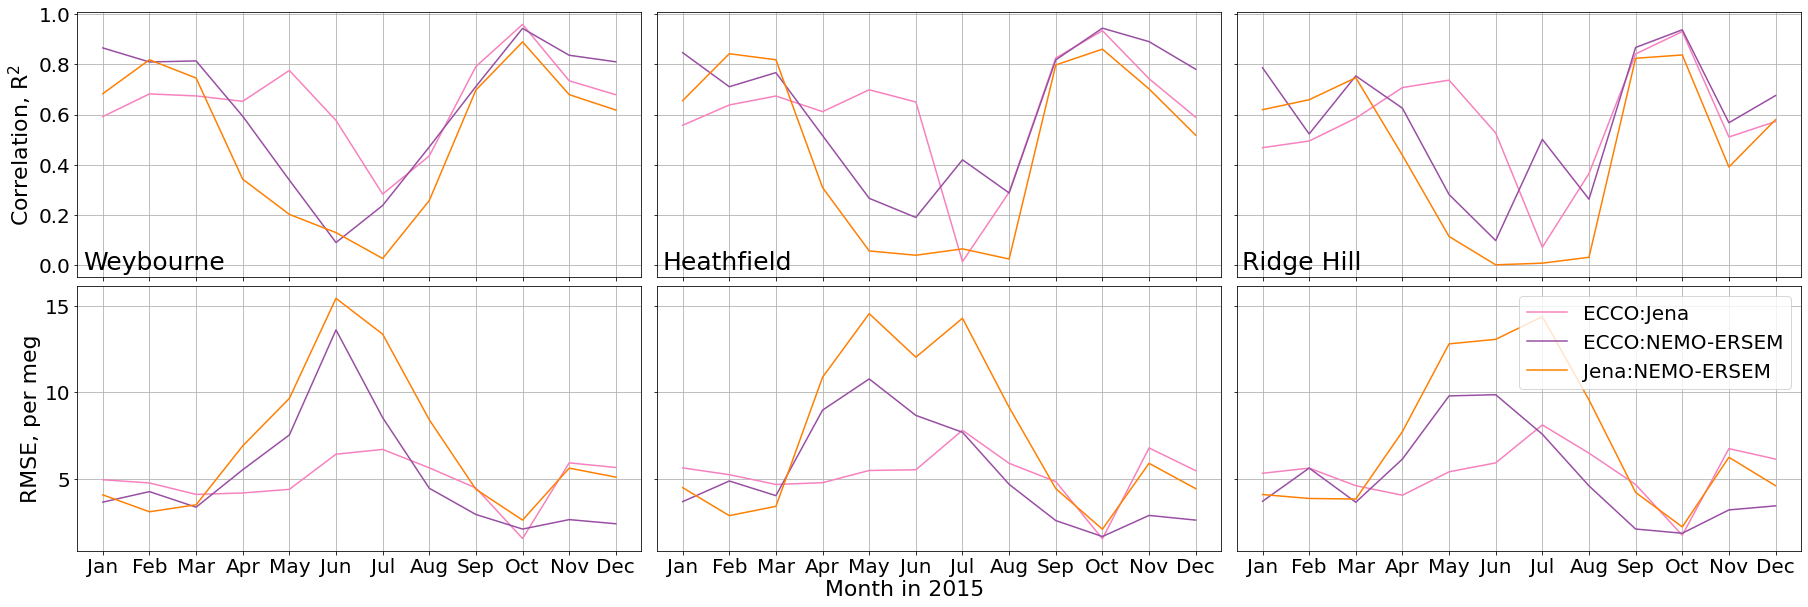

In [31]:
if len(months)>=12:
    sites_plot = ['WAO', 'HFD', 'RGL']

    plot_info_corr = {'unfiltered': {'ls':'-',
                                     'correlation': correlations_models,
                                     'rmse': rmse_models,
                                     'color': {'ecco-jena': '#f781bf', 'ecco-nemo': '#984ea3', 'jena-nemo': '#ff7f00'}}
    }

    ncols = len([site for site in sites if site in sites_plot])
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(25, 8), sharex=True, sharey='row', constrained_layout=True)

    for info in plot_info_corr.values():
        corr_plot = [[axes.flatten()[ss].plot(apo_plot_info.month_names.values(), [rr[sim] for rr in info['correlation'][site].values()],
                                              label=f'{apo_plot_info.model_names[sim.split("-")[0]]}:{apo_plot_info.model_names[sim.split("-")[1]]}',
                                              ls=info['ls'], color=info['color'][sim])
                     for sim in info['correlation'][site][1].keys()] for ss, site in enumerate(sites) if site in sites_plot]

        rmse_plot = [[axes.flatten()[ss+len(sites)].plot(apo_plot_info.month_names.values(), [rr[sim] for rr in info['rmse'][site].values()],
                                                              label=f'{apo_plot_info.model_names[sim.split("-")[0]]}:{apo_plot_info.model_names[sim.split("-")[1]]}',
                                                              ls=info['ls'], color=info['color'][sim])
                    for sim in info['correlation'][site][1].keys()] for ss, site in enumerate(sites) if site in sites_plot]

    ticks = [ax.tick_params(labelsize=20) for ax in axes.flatten()]
    grid = [ax.grid() for ax in axes.flatten()]
    xlabels = [ax.set_xlabel('') for ax in axes.flatten()]
    xlabel = fig.text(0.5, 0, f'Month in {year}', va='top', ha='center', fontsize=22)
    
    if len(sites_plot)>1 and len(sites)>1:
        legend = axes[1][-1].legend(loc="upper right", fontsize=20)
        ylabels = [axes[ll][0].set_ylabel(label, fontsize=22)
                   for ll, label in enumerate([r'Correlation, R$^2$', 'RMSE, per meg'])]
        [axes[0][ss].text(0.01, 0.01, site_text, va='bottom', transform=axes[0][ss].transAxes, fontsize=25) for ss, site_text in enumerate(sites.values())]
    else:
        legend = axes[0].legend(bbox_to_anchor=(1,1), loc="upper left", fontsize=20)
        ylabels = [axes[ll].set_ylabel(label, fontsize=25)
                   for ll, label in enumerate([r'Correlation, R$^2$', 'RMSE, per meg'])]

    date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
    filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                            f'APO_modelcorrelations_{"-".join(sites_plot)}_{date_str}.png')

    if save: 
        print(f'Saving to {filename}')
        fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Import the observations

In [21]:
apo_obs = {month: get_obs(list(sites.keys()), 'APO', start_date, end_dates[month], keep_missing=True)
           for month, start_date in start_dates.items()}
apo_obs_year = get_obs(list(sites.keys()), 'APO', f'{year}-01-01', f'{year+1}-01-01', keep_missing=True)

Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20211221.nc
... slicing from 2015-01-01 00:00:00 to 2015-01-31 23:59:58.999999999
Getting APO data for HFD...
Getting APO data for RGL...
Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20211221.nc
... slicing from 2015-02-01 00:00:00 to 2015-02-28 23:59:58.999999999
Getting APO data for HFD...
Getting APO data for RGL...
Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20211221.nc
... slicing from 2015-03-01 00:00:00 to 2015-03-31 23:59:58.999999999
Getting APO data for HFD...
Getting APO data for RGL...
Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20211221.nc
... slicing from 2015-

## Plot the model and observations

In [40]:
add_xlabel = False #True #
legend_outside = False #True

Saving to /user/work/vf20487/Figures/APO_timeseries/APO_timeseries_WAO-HFD-RGL_201508-201512.png


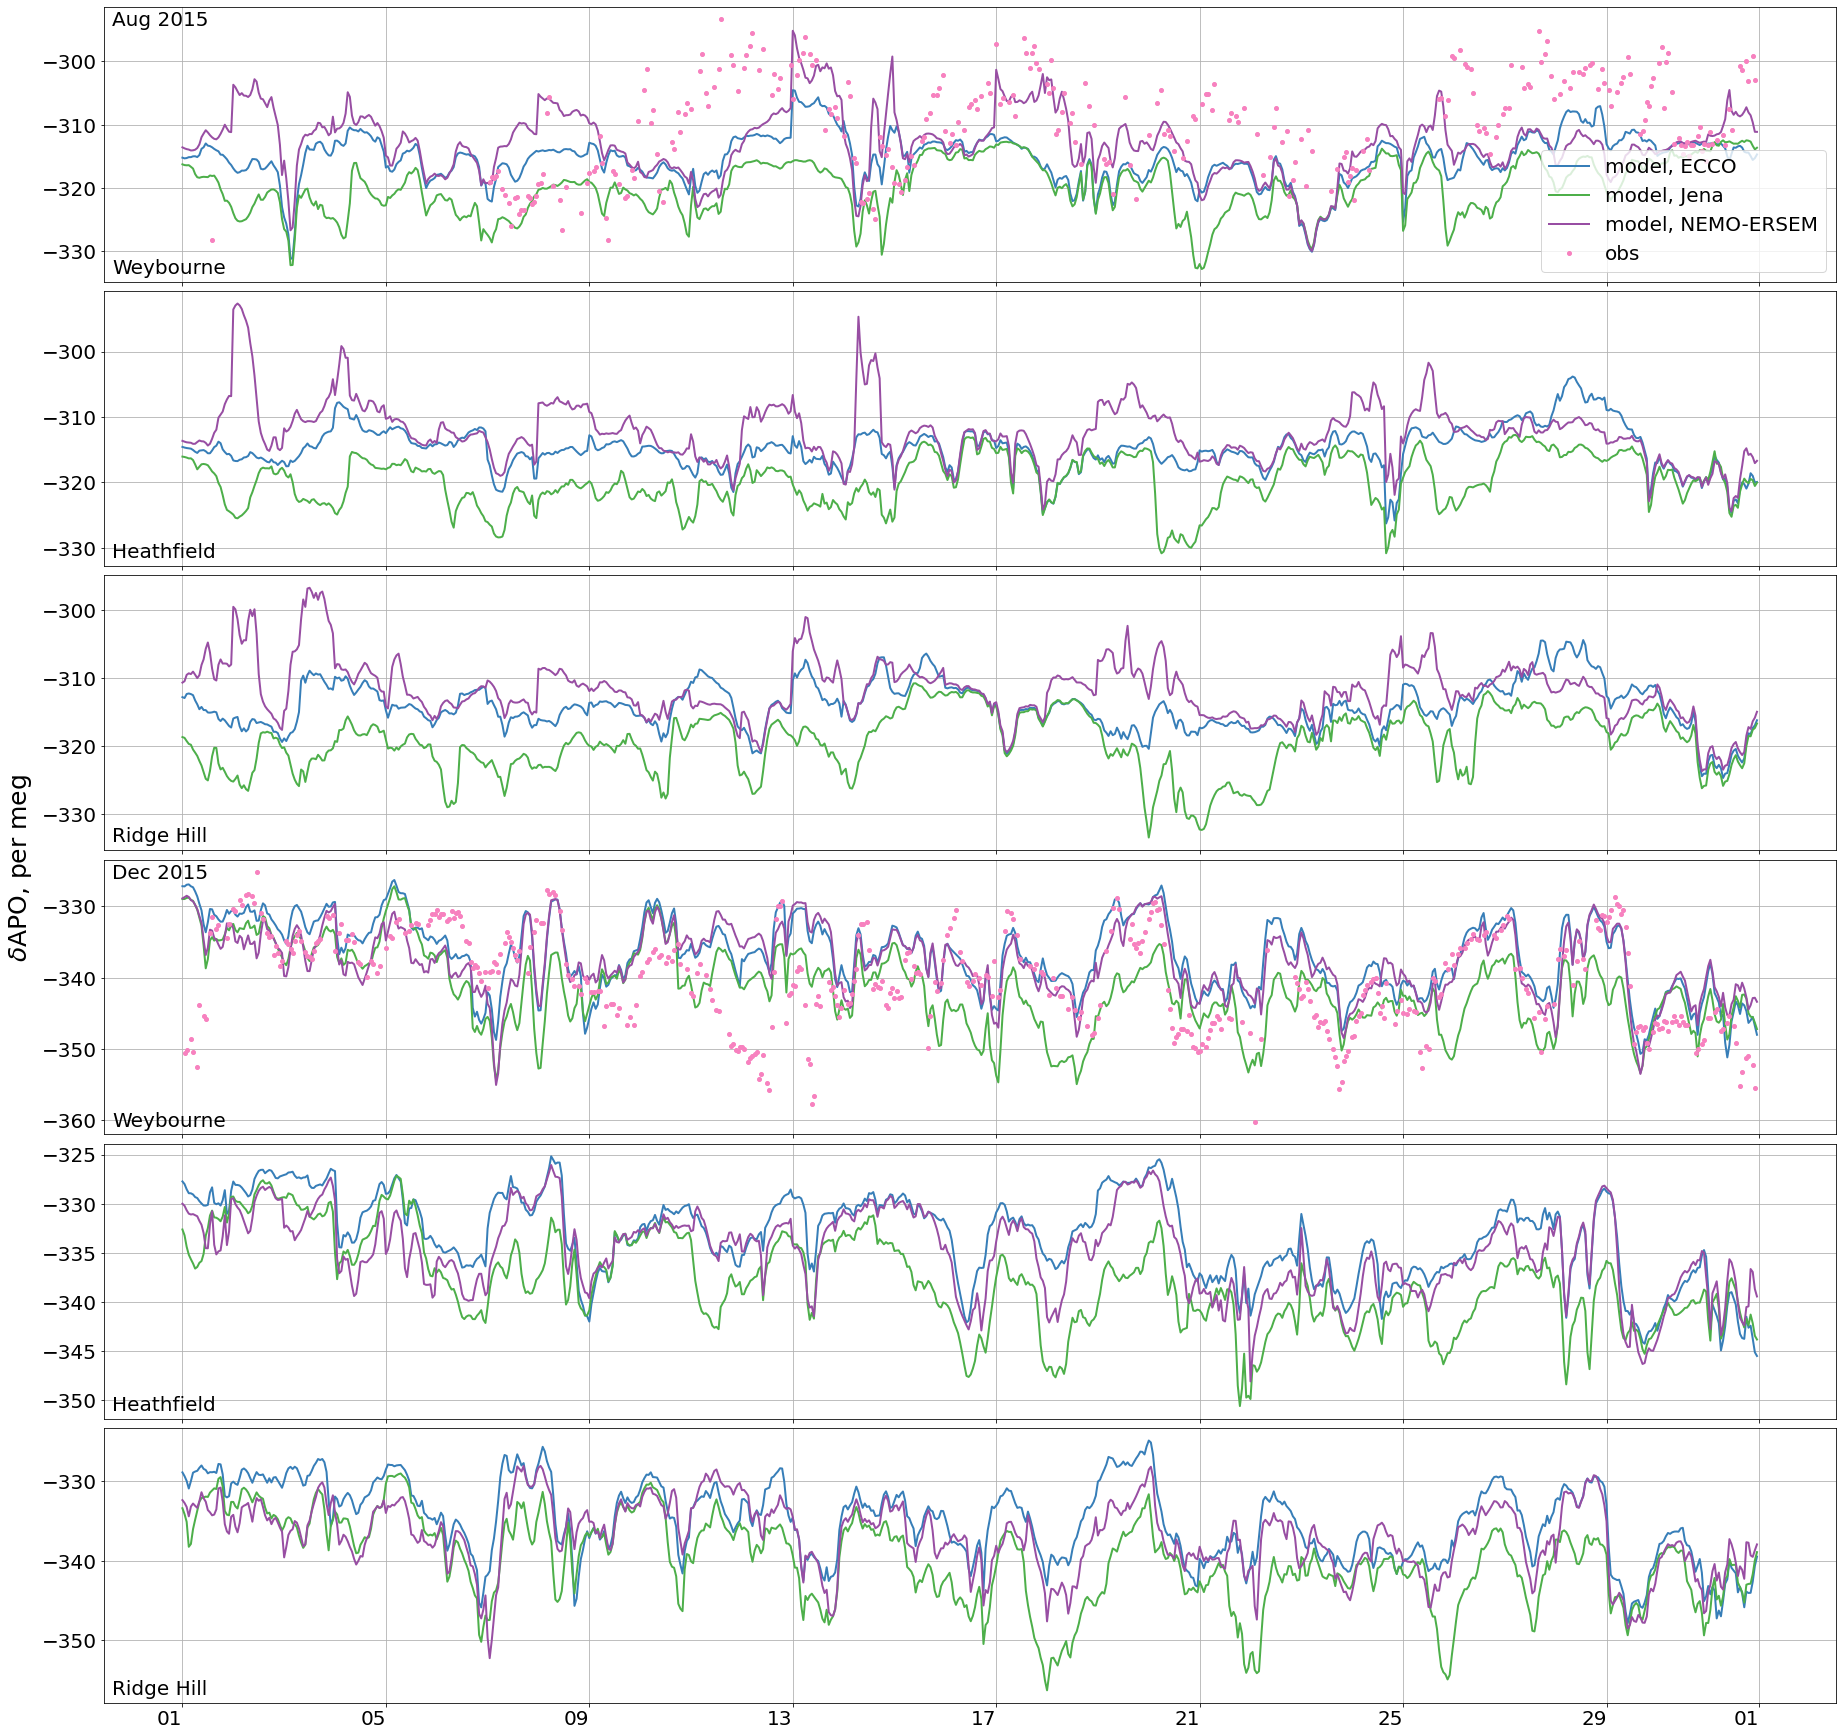

In [41]:
row_size = 3 if len(months) in [4, 6] or poster else 4 if any([len(var)>1 for var in [months, sites]]) else 8
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(25, row_size*nrows), constrained_layout=True)
axes = axes if type(axes)==np.ndarray else [axes]

model_plots = {site: {month: {sim: apo_sim.plot(ax=axes[ss+mm*len(sites)], color=apo_plot_info.colors[sim.lower()], lw=2,
                                                label=f'model, {apo_plot_info.model_names[sim.lower()]}')
                              for sim, apo_sim in apo_month.items()}
                      for mm, (month, apo_month) in enumerate(apo_site.items())}
               for ss, (site, apo_site) in enumerate(apo_model.items())}
obs_plots = {month: {site: apo_site[0].mf.plot(ax=axes[ss+mm*len(sites)], color='#f781bf', label='obs', marker='o', ls='none', markersize=4)
                           if len(apo_site)>0 else None
                     for ss, (site, apo_site) in enumerate(apo_month.items())}
             for mm, (month, apo_month) in enumerate(apo_obs.items())}

if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       ticks = [axes[ii].xaxis.set_ticklabels([]) for ii in range(len(axes)) if ii!=len(sites)*len(months)-1]
       text = [axes[mm*len(sites)].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm*len(sites)].transAxes, va='top', fontsize=20)
               for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

if len(sites)>1:
       [axes[ii].xaxis.set_ticklabels([]) for ii in [i for i in range(0, len(axes)) if (i+1)%len(sites)!=0]]
       sites_text = list(sites.values())*len(months)
       [ax.text(0.005, 0.015, sites_text[aa], va='bottom', transform=ax.transAxes, fontsize=20) for aa, ax in enumerate(axes)]

legend = axes[0].legend(fontsize=20, bbox_to_anchor = (1, 1.05)) if legend_outside else \
         axes[0].legend(loc='lower right', fontsize=20)
grid = [ax.grid() for ax in axes]
xlabels = [ax.set_xlabel('') for ax in axes]
if add_xlabel:
       [axes[m*len(sites)+(len(sites)-1)].set_xlabel(f'Day in {apo_plot_info.month_names[month]}', fontsize=25)
       for m, month in enumerate(months)]
if len(axes)>1:
       ylabels = [ax.set_ylabel('') for ax in axes]
       ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)
else: ylabels = axes[0].set_ylabel(r'$\delta$APO, per meg', fontsize=30)

if poster:
       text = axes[-1].text(1.01, 0.7, 'Fig. 2:',
              transform=axes[-1].transAxes, va='top', fontsize=20) 
       text = axes[-1].text(1.01, 0.55, r'Modelled and' + '\nobserved $\delta$APO at' + '\nWeybourne during' + '\nAugust and December' + '\n2014.',
              transform=axes[-1].transAxes, va='top', fontsize=20)

date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                        f'APO_timeseries_{"-".join(sites)}_{date_str}.png')
print(f'Saving to {filename}')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Investigate the correlations

Calculate the root mean square error (RMSE) and pearson correlation coefficient

### RMSE: 
This will be smaller for a better fit

$rmse = \sqrt{\sum (P-O)^2 / N}$

$P$ = predicted values (model) \
$O$ = observed values \
$N$ = number of data points

### Pearson correlation coefficient:
This is between 0 and 1, and closer to 1 for a better fit \
(or between 0 and -1 for an anti-correlation)

Xarray has a function to calculate this, using this formula:

$R = \frac{n \sum xy - (\sum x)(\sum y)}{\sqrt{(n \sum x^2 - (\sum x)^2) (n \sum y^2 - (\sum y)^2)}} $

$x, y$ = the two datasets \
$n$ = number of data points

We plot $R^2$


In [22]:
rmse = {site: {month: {model: (((apo_sim.sel(time=slice(start_dates[month], end_dates[month])) - 
                                 apo_obs[month][site][0].mf.sel(time=slice(start_dates[month], end_dates[month])))**2).mean().values)**0.5
                       for model, apo_sim in apo_month.items() if len(apo_obs[month][site])>0}
               for month, apo_month in apo_site.items()}
        for site, apo_site in apo_model.items()}

correlations = {site: {month: {model: xr.corr(apo_obs[month][site][0].mf.sel(time=slice(start_dates[month], end_dates[month])),
                                              apo_sim.sel(time=slice(start_dates[month], end_dates[month])))**2
                               for model, apo_sim in apo_month.items() if len(apo_obs[month][site])>0}
                       for month, apo_month in apo_site.items()}
                for site, apo_site in apo_model.items()}


In [23]:
corr = {}
for key, value in correlations['WAO'].items():
    for k, v in value.items():
        if k not in corr.keys():
            corr[k] = {}
        corr[k][key] = float(v.values)
rmse_ = {}
for key, value in rmse['WAO'].items():
    for k, v in value.items():
        if k not in rmse_.keys():
            rmse_[k] = {}
        rmse_[k][key] = float(v)

In [24]:
corr_seasons = {season: {model: [corr_model[month] for month in season_months]
                         for model, corr_model in corr.items()}
                for season, season_months in apo_plot_info.seasons.items()}
corr_seasons_ave = {season: {model: np.nanmean(np.array(corr_model))
                             for model, corr_model in corr_season.items()}
                    for season, corr_season in corr_seasons.items()}
corr_seasons_ave

for season, corr_season in corr_seasons_ave.items():
    print(f'{season}:')
    [print(f'       {model}: {corr_model}') for model, corr_model in corr_season.items()]

Spring:
       ECCO: 0.38299293133073814
       Jena: 0.35268446369626966
       NEMO: 0.272892138125576
Summer:
       ECCO: 0.11398033580740424
       Jena: 0.056766373852495944
       NEMO: 0.020863772189802718
Autumn:
       ECCO: 0.31099068693922827
       Jena: 0.21240684243146934
       NEMO: 0.28504337895264914
Winter:
       ECCO: 0.22741472821370343
       Jena: 0.12389192589305477
       NEMO: 0.1775756625094931


In [25]:
print(f'average correlation: {np.nanmean([np.nanmean(list(corr_model.values())) for model, corr_model in corr.items()])}')
print(f'average RMSE: {np.nanmean([np.nanmean(list(rmse_model.values())) for model, rmse_model in rmse_.items()])}')

average correlation: 0.2114586033284904
average RMSE: 10.556949106784467


In [26]:
print('RMSE')
print_rmse = [[print(f'{site}, {apo_plot_info.month_names[month]} rmse:    ECCO: {rmse_month["ECCO"]};   Jena: {rmse_month["Jena"]};   '+
                     f'NEMO: {rmse_month["NEMO"]}; average: {np.array(list(rmse_month.values())).mean()}')
               for month, rmse_month in rmse_site.items() if len(rmse_month)>0]
              for site, rmse_site in rmse.items()]
print('\nCorrelation')
print_corr = [[print(f'{site}, {apo_plot_info.month_names[month]} correlation:    ECCO: {corr_month["ECCO"].values};   Jena: {corr_month["Jena"].values};   '+
                     f'NEMO: {corr_month["NEMO"].values}; average: {np.array(list(corr_month.values())).mean()}')
               for month, corr_month in corr_site.items() if len(corr_month)>0]
              for site, corr_site in correlations.items()]

RMSE
WAO, Jan rmse:    ECCO: 8.908957949959795;   Jena: 9.533396177176924;   NEMO: 9.85600876284879; average: 9.432787629995168
WAO, Feb rmse:    ECCO: 14.524644169683596;   Jena: 16.592856351880744;   NEMO: 16.98779065382067; average: 16.03509705846167
WAO, Mar rmse:    ECCO: 8.288506947724366;   Jena: 8.42954179778181;   NEMO: 8.724508092917043; average: 8.480852279474407
WAO, Apr rmse:    ECCO: 9.812977527753503;   Jena: 10.727565683057723;   NEMO: 10.938948753133317; average: 10.493163987981514
WAO, May rmse:    ECCO: 9.9533550460661;   Jena: 10.710310584104645;   NEMO: 11.248997156602508; average: 10.637554262257751
WAO, Jun rmse:    ECCO: 16.34317805269826;   Jena: 20.48820969640394;   NEMO: 16.02497329245177; average: 17.61878701385132
WAO, Jul rmse:    ECCO: 9.792137382151978;   Jena: 13.772662127705996;   NEMO: 12.92558405851686; average: 12.163461189458276
WAO, Aug rmse:    ECCO: 8.774562157021391;   Jena: 12.009621112314651;   NEMO: 8.788231196605816; average: 9.857471488647

## Apply masks

Filter data for only daytime values

In [27]:
apo_model_day = {site: {month: {sim: apo_filter.filter_time(dataset = apo_sim,
                                                            site = 'WAO',
                                                            hour_start = 11,
                                                            hour_end = 15)
                                for sim, apo_sim in apo_month.items() if len(apo_month)>0}
                        for month, apo_month in apo_site.items()}
                 for site, apo_site in apo_model.items()}
apo_obs_day = {month: {site: apo_filter.filter_time(dataset = apo_site[0].mf,
                                                    site = 'WAO',
                                                    hour_start = 11,
                                                    hour_end = 15)
                       for site, apo_site in apo_month.items() if len(apo_site)>0}
               for month, apo_month in apo_obs.items()}

In [28]:
rmse_day = {site: {month: {model: (((apo_sim.sel(time=slice(start_dates[month], end_dates[month])) - 
                                     apo_obs[month][site][0].mf.sel(time=slice(start_dates[month], end_dates[month])))**2).mean().values)**0.5
                       for model, apo_sim in apo_month.items() if len(apo_obs[month][site])>0}
               for month, apo_month in apo_site.items()}
        for site, apo_site in apo_model_day.items()}

correlations_day = {site: {month: {model: xr.corr(apo_obs[month][site][0].mf.sel(time=slice(start_dates[month], end_dates[month])),
                                                  apo_sim.sel(time=slice(start_dates[month], end_dates[month])))**2
                               for model, apo_sim in apo_month.items() if len(apo_obs[month][site])>0}
                       for month, apo_month in apo_site.items()}
                for site, apo_site in apo_model_day.items()}

In [29]:
print('RMSE')
print_rmse = [[print(f'{site}, {apo_plot_info.month_names[month]} rmse:    ECCO: {rmse_month["ECCO"]};   ' +
                     f'Jena: {rmse_month["Jena"]};   NEMO: {rmse_month["NEMO"]}; average: {np.array(list(rmse_month.values())).mean()}')
               for month, rmse_month in rmse_site.items() if len(rmse_month)>0]
              for site, rmse_site in rmse_day.items()]
print('\nCorrelation')
print_corr = [[print(f'{site}, {apo_plot_info.month_names[month]} correlation:    ECCO: {corr_month["ECCO"].values};   Jena: {corr_month["Jena"].values};   ' +
                     f'NEMO: {corr_month["NEMO"].values}; average: {np.array(list(corr_month.values())).mean()}')
               for month, corr_month in corr_site.items() if len(corr_month)>0]
              for site, corr_site in correlations_day.items()]

RMSE
WAO, Jan rmse:    ECCO: 9.138894479400463;   Jena: 9.451704244041427;   NEMO: 9.704491523968303; average: 9.431696749136732
WAO, Feb rmse:    ECCO: 13.18323325700574;   Jena: 16.684854812637294;   NEMO: 16.867574469117862; average: 15.578554179586966
WAO, Mar rmse:    ECCO: 8.310209073935178;   Jena: 7.727028894033223;   NEMO: 8.648444928284832; average: 8.228560965417744
WAO, Apr rmse:    ECCO: 9.458125377553944;   Jena: 10.1976156713499;   NEMO: 9.9500930286322; average: 9.868611359178681
WAO, May rmse:    ECCO: 9.0264177385099;   Jena: 9.74267558922036;   NEMO: 11.51350283347047; average: 10.094198720400243
WAO, Jun rmse:    ECCO: 17.650141740927342;   Jena: 17.994899787782646;   NEMO: 17.271694970820043; average: 17.63891216651001
WAO, Jul rmse:    ECCO: 10.596078310796557;   Jena: 13.279525374095417;   NEMO: 12.573570671281994; average: 12.149724785391323
WAO, Aug rmse:    ECCO: 8.3391995685105;   Jena: 10.491942714228259;   NEMO: 9.225787327334045; average: 9.35230987002427


### Mask high ocean contributions

### Plot correlations

Saving to /user/work/vf20487/Figures/APO_timeseries/APO_correlations_WAO_2015.png


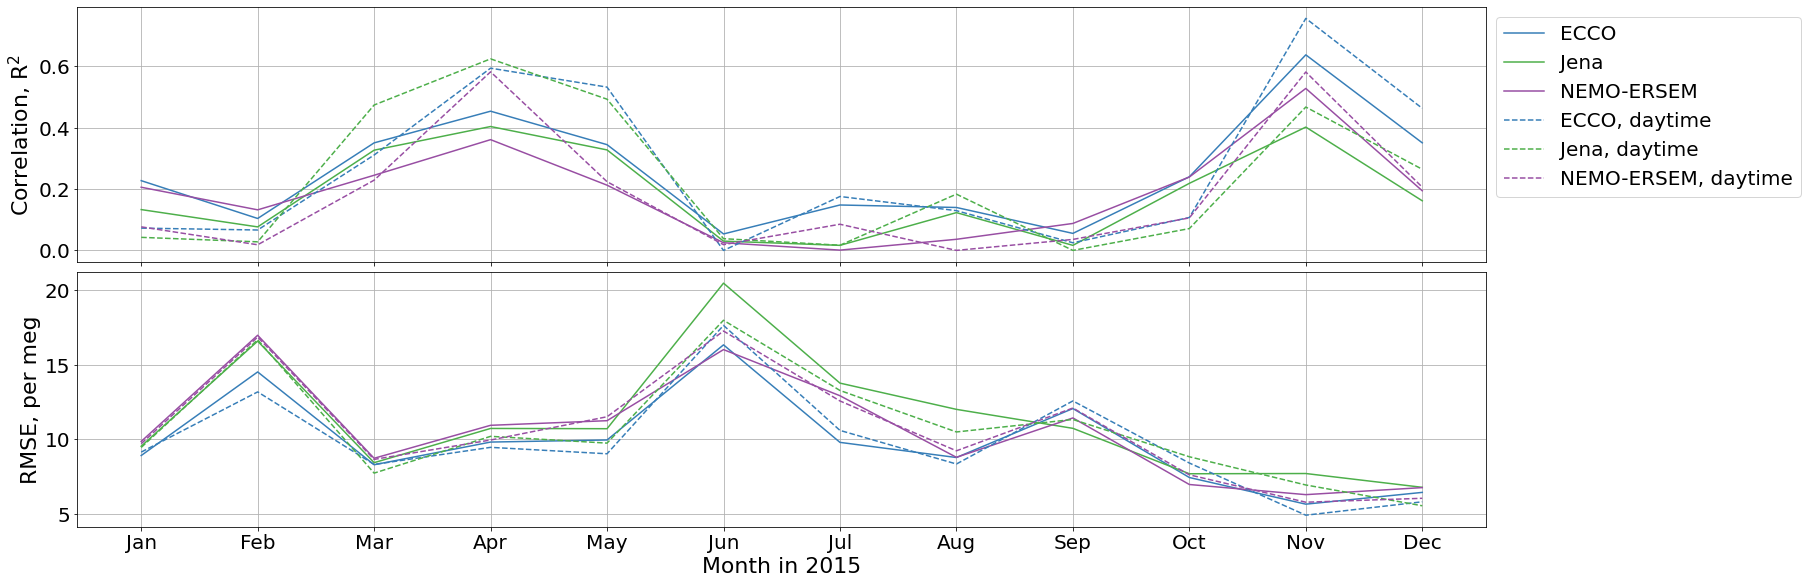

In [30]:
if len(months)>=12:
    sites_plot = ['WAO']
    sites_plot = [site for site in sites_plot if site in sites]

    plot_info_corr = {'unfiltered': {'label': '', 'ls':'-',
                                    'correlation': correlations,
                                    'rmse': rmse},
                    'daytime': {'label': ', daytime', 'ls': '--',
                                'correlation': correlations_day,
                                'rmse': rmse_day}}

    fig, axes = plt.subplots(nrows=2*len(sites_plot), ncols=1, figsize=(25, 8*len(sites_plot)), sharex=True, constrained_layout=True)

    for info in plot_info_corr.values():
        corr_plot = [[axes[ss].plot(apo_plot_info.month_names.values(), [rr[apo_plot_info.model_names[sim].split('-')[0]] for rr in info['correlation'][site].values()],
                                    color=apo_plot_info.colors[sim], label=f'{apo_plot_info.model_names[sim]}{info["label"]}', ls=info['ls'])
                    for sim in apo_labels.keys() if sim!='ff'] for ss, site in enumerate(sites_plot)]

    for info in plot_info_corr.values():
        rmse_plot = [[axes[len(sites_plot)+ss].plot(apo_plot_info.month_names.values(), [rr[apo_plot_info.model_names[sim].split('-')[0]] for rr in info['rmse'][site].values()],
                                                    color=apo_plot_info.colors[sim], label=f'{apo_plot_info.model_names[sim]}{info["label"]}', ls=info['ls'])
                    for sim in apo_labels.keys() if sim!='ff'] for ss, site in enumerate(sites_plot)]

    ticks = [ax.tick_params(labelsize=20) for ax in axes]
    # legend = axes[0].legend(loc='lower left', fontsize=16)
    legend = axes[0].legend(bbox_to_anchor=(1,1), loc="upper left", fontsize=20)
    grid = [ax.grid() for ax in axes]
    xlabels = [ax.set_xlabel('') for ax in axes]
    xlabel = axes[1].set_xlabel(f'Month in {year}', fontsize=22)
    ylabels = [axes[ll].set_ylabel(label, fontsize=22)
            for ll, label in enumerate([r'Correlation, R$^2$', 'RMSE, per meg'])]

    date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
    filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                            f'APO_correlations_{"-".join(sites_plot)}_{date_str}.png')
    
    print(f'Saving to {filename}')
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Plot the model and observations

In [45]:
add_xlabel = False #True #
legend_outside = True
poster = True

Saving to /user/work/vf20487/Figures/APO_timeseries/APO_timeseries_WAO_2015.png


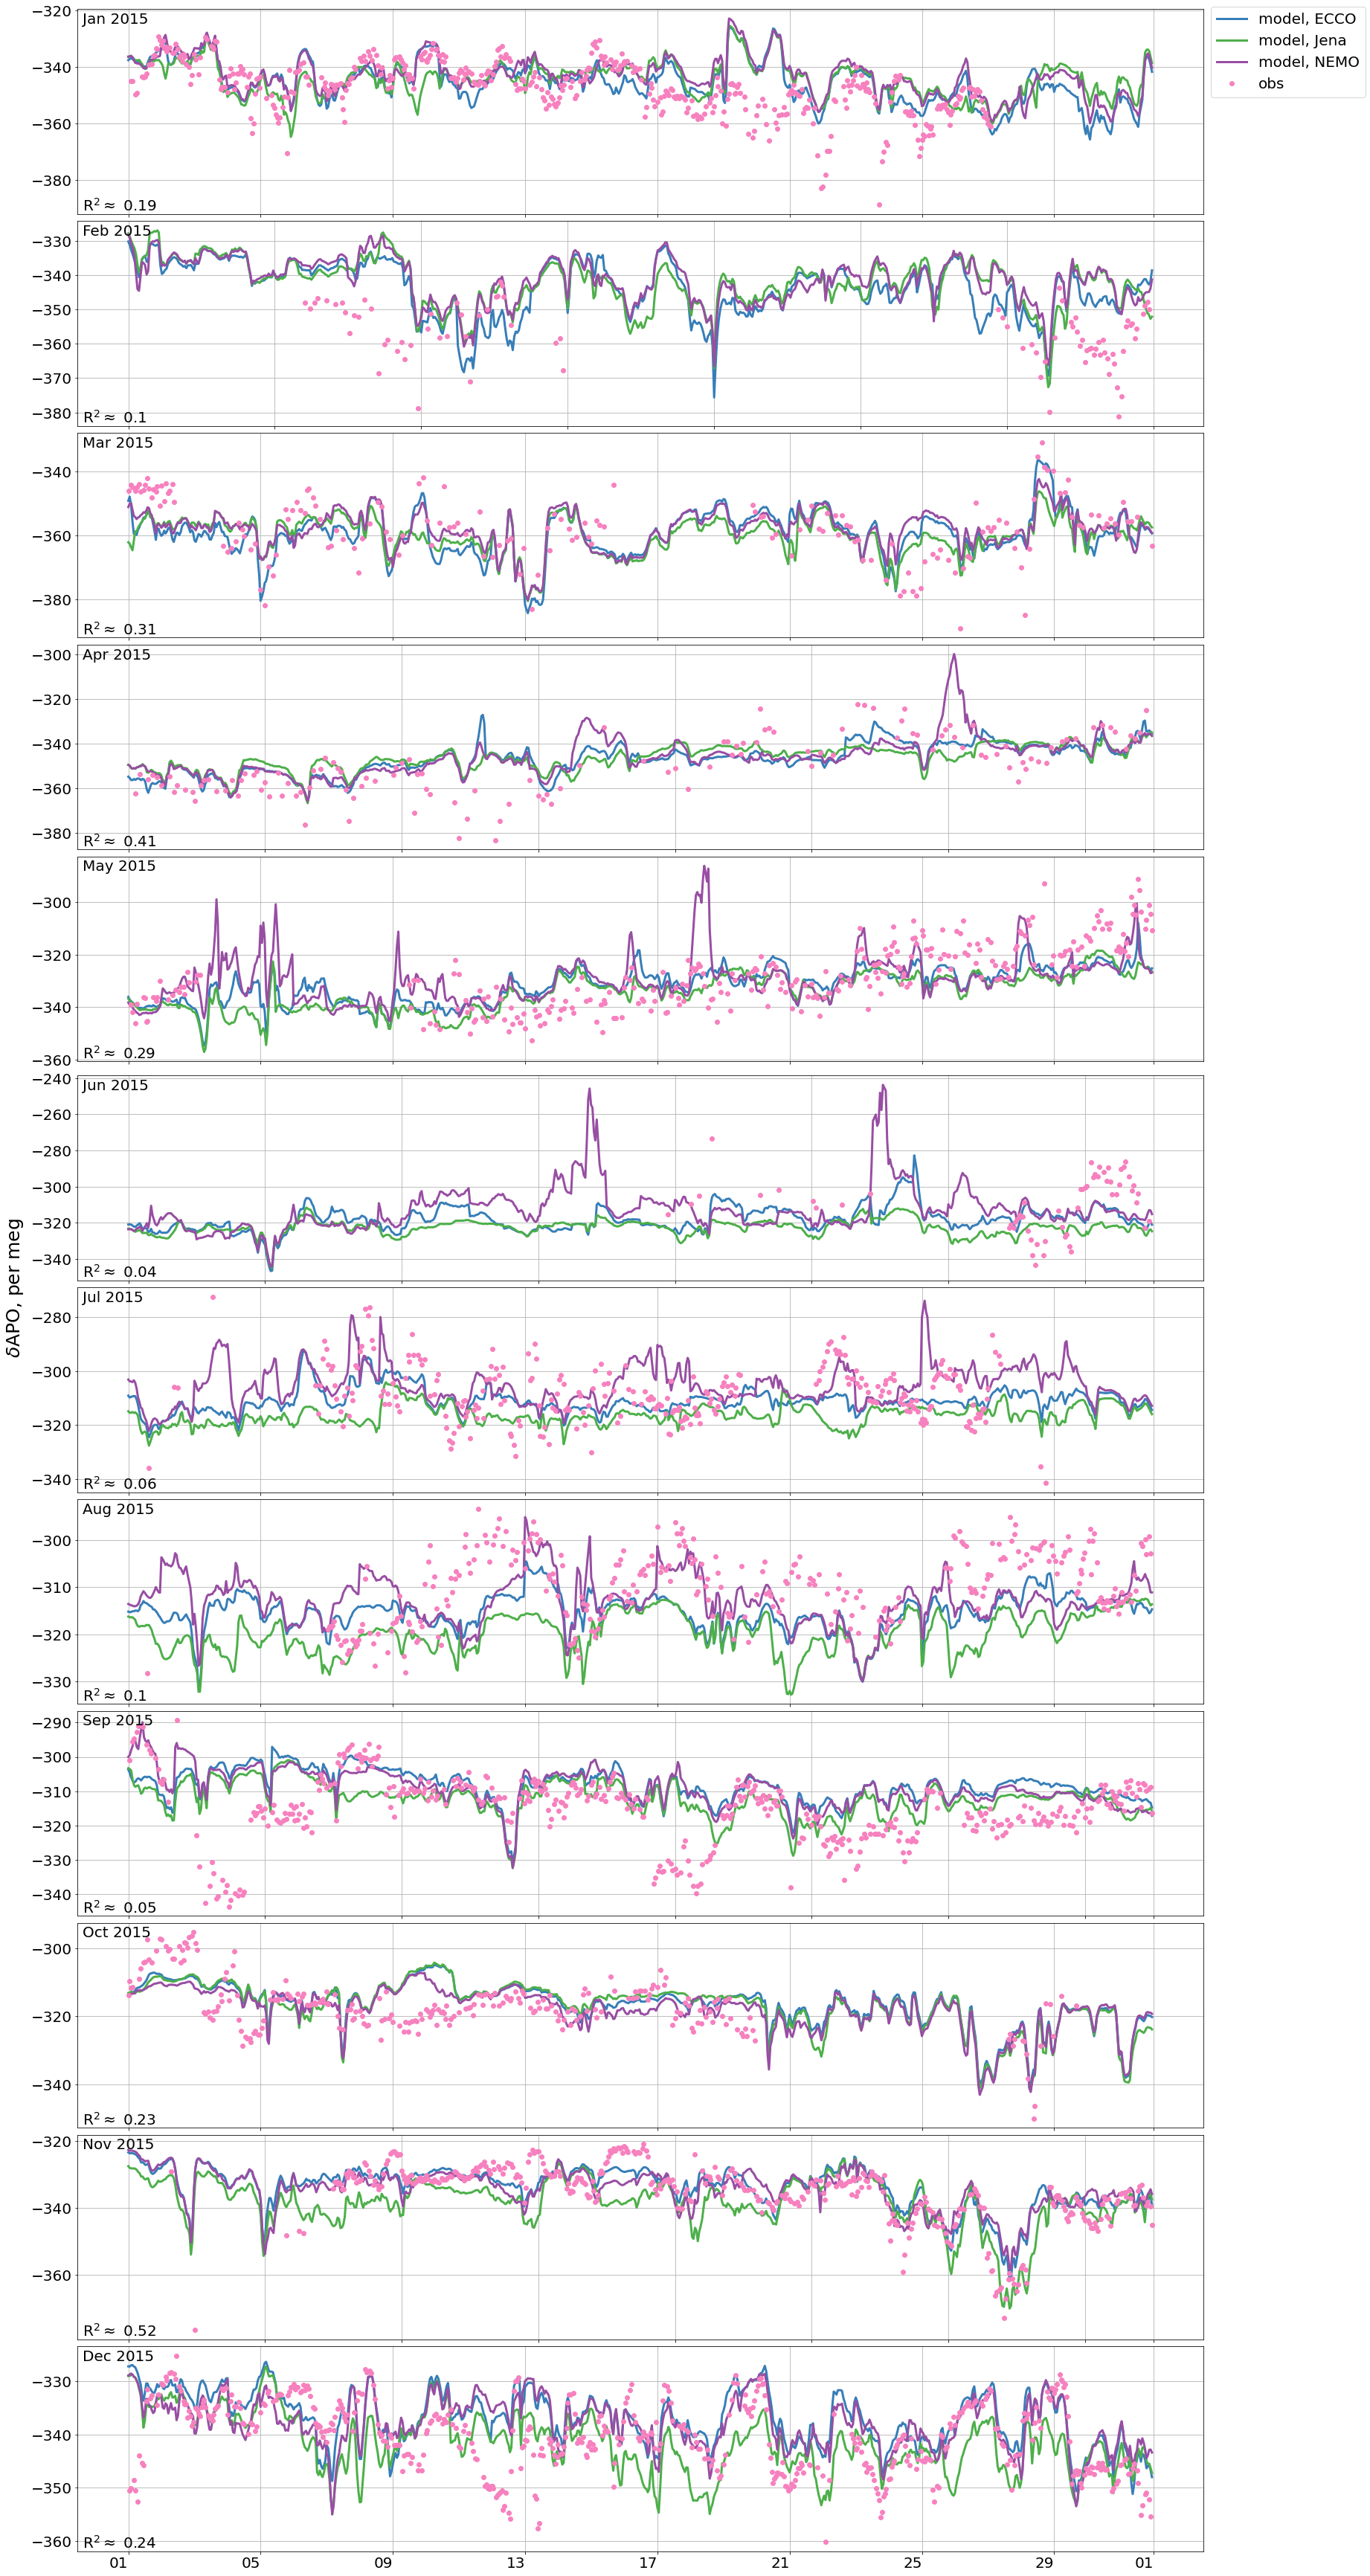

In [122]:
row_size = 3 if len(months) in [4, 6] or poster else 4 if any([len(var)>1 for var in [months, sites]]) else 8
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(25, row_size*nrows), constrained_layout=True)
axes = axes if type(axes)==np.ndarray else [axes]

model_plots = {site: {month: {sim: apo_sim.plot(ax=axes[ss+mm*len(sites)], color=apo_plot_info.colors[sim.lower()], label=f'model, {sim}', lw=3)
                              for sim, apo_sim in apo_month.items()}
                      for mm, (month, apo_month) in enumerate(apo_site.items())}
               for ss, (site, apo_site) in enumerate(apo_model.items())}
obs_plots = {month: {site: apo_site[0].mf.plot(ax=axes[ss+mm*len(sites)], color='#f781bf', label='obs', marker='o', ls='none', markersize=6)
                           if len(apo_site)>0 else None
                     for ss, (site, apo_site) in enumerate(apo_month.items())}
             for mm, (month, apo_month) in enumerate(apo_obs.items())}

corr_text = {site: {month: axes[ss+mm*len(sites)].text(0.005, 0.015, r'R$^2 \approx$ '+f'{np.round(np.nanmean(list(corr_month.values())), 2)}',
                                                       transform=axes[ss+mm*len(sites)].transAxes, fontsize=20)
                    for mm, (month, corr_month) in enumerate(corr_site.items())}
             for ss, (site, corr_site) in enumerate(correlations.items())}

if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       ticks = [axes[ii].xaxis.set_ticklabels([]) for ii in range(len(axes)) if ii!=len(sites)*len(months)-1]
       text = [axes[mm*len(sites)].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm*len(sites)].transAxes, va='top', fontsize=20)
               for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

if len(sites)>1:
       [axes[ii].xaxis.set_ticklabels([]) for ii in [i for i in range(0, len(axes)) if (i+1)%len(sites)!=0]]
       sites_text = list(sites.values())*len(months)
       [ax.text(0.01, 0.05, sites_text[aa], va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]

legend = axes[0].legend(fontsize=20, bbox_to_anchor = (1, 1.05)) if legend_outside else \
         axes[0].legend(loc='lower right', fontsize=20)
grid = [ax.grid() for ax in axes]
xlabels = [ax.set_xlabel('') for ax in axes]
if add_xlabel:
       [axes[m*len(sites)+(len(sites)-1)].set_xlabel(f'Day in {apo_plot_info.month_names[month]}', fontsize=25)
       for m, month in enumerate(months)]
if len(axes)>1:
       ylabels = [ax.set_ylabel('') for ax in axes]
       ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)
else: ylabels = axes[0].set_ylabel(r'$\delta$APO, per meg', fontsize=30)

if poster:
       text = axes[-1].text(1.01, 0.7, 'Fig. 2:',
              transform=axes[-1].transAxes, va='top', fontsize=20) 
       text = axes[-1].text(1.01, 0.55, r'Modelled and' + '\nobserved $\delta$APO at' + '\nWeybourne during' + '\nAugust and December' + '\n2014.',
              transform=axes[-1].transAxes, va='top', fontsize=20)

date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                        f'APO_timeseries_{"-".join(sites)}_{date_str}.png')
print(f'Saving to {filename}')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Average over different time periods

Try averaging over a day, a week, and a month to see how time resolution affects the correlation with the obs

In [176]:
apo_model_diff_res = {site: {model: {res_name: apo_mod.resample(time=res).mean()
                                     for res_name, res in {'hour': '1H', 'day': '1D', 'week': 'W', 'month': '1M'}.items()}
                             for model, apo_mod in apo_site.items()}
                      for site, apo_site in apo_model_year.items()}
apo_obs_diff_res = {site: {res_name: apo_site[0].mf.resample(time=res).mean()
                           for res_name, res in {'hour': '1H', 'day': '1D', 'week': 'W', 'month': '1M'}.items()}
                    for site, apo_site in apo_obs_year.items()}

In [181]:
rmse_diff_res = {site: {month: {model: {res: (((apo_res.sel(time=slice(start_dates[month], end_dates[month])) - 
                                                apo_obs_diff_res[site][res].sel(time=slice(start_dates[month], end_dates[month])))**2).mean().values)**0.5
                                        for res, apo_res in apo_sim.items()}
                                for model, apo_sim in apo_site.items() if len(apo_obs[month][site])>0}
                        for month in months}
                for site, apo_site in apo_model_diff_res.items()}

correlations_diff_res = {site: {month: {model: {res: xr.corr(apo_obs_diff_res[site][res].sel(time=slice(start_dates[month], end_dates[month])),
                                                             apo_res.sel(time=slice(start_dates[month], end_dates[month])))**2
                                                for res, apo_res in apo_sim.items()}
                                        for model, apo_sim in apo_site.items() if len(apo_obs[month][site])>0}
                                for month in months}
                         for site, apo_site in apo_model_diff_res.items()}

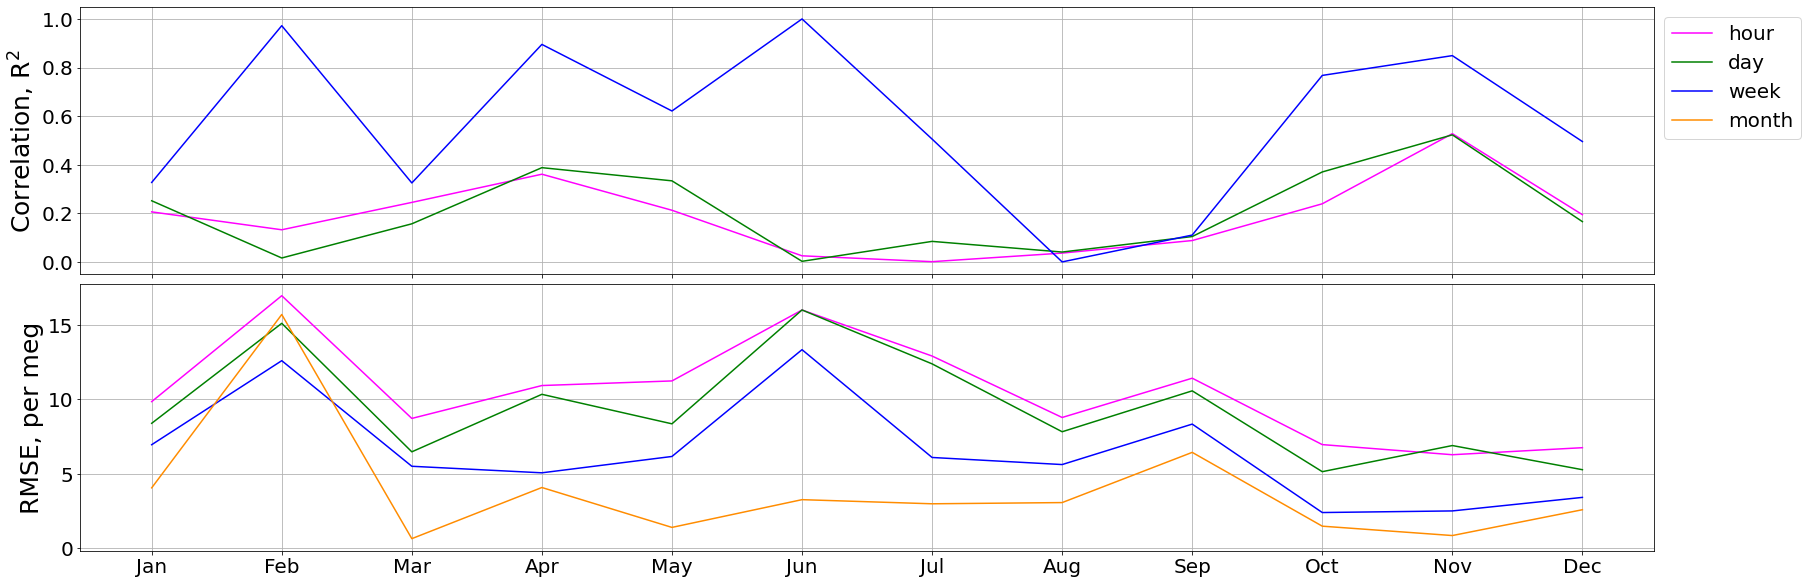

In [182]:
if len(months)>=12:
    sites_plot = ['WAO']
    model_plot = 'NEMO'

    plot_info_corr = {'unfiltered': {'label': '', 'ls':'-',
                                    'correlation': correlations_diff_res,
                                    'rmse': rmse_diff_res}}
    
    res_colors = {'hour': 'magenta', 'day': 'green', 'week': 'blue', 'month': 'darkorange'}

    fig, axes = plt.subplots(nrows=2*len(sites_plot), ncols=1, figsize=(25, 8*len(sites_plot)), sharex=True, constrained_layout=True)

    for info in plot_info_corr.values():
        corr_plot = [[axes[ss].plot(apo_plot_info.month_names.values(), [rr[model_plot][res] for rr in info['correlation'][site].values()],
                                    color=res_col, label=res, ls=info['ls'])
                      for res, res_col in res_colors.items()] for ss, site in enumerate(sites_plot)]

    for info in plot_info_corr.values():
        rmse_plot = [[axes[len(sites_plot)+ss].plot(apo_plot_info.month_names.values(), [rr[model_plot][res] for rr in info['rmse'][site].values()],
                                                    color=res_col, label=res, ls=info['ls'])
                      for res, res_col in res_colors.items()] for ss, site in enumerate(sites_plot)]

    ticks = [ax.tick_params(labelsize=20) for ax in axes]
    # legend = axes[0].legend(loc='lower left', fontsize=16)
    legend = axes[0].legend(bbox_to_anchor=(1,1), loc="upper left", fontsize=20)
    grid = [ax.grid() for ax in axes]
    xlabels = [ax.set_xlabel('') for ax in axes]
    ylabels = [axes[ll].set_ylabel(label, fontsize=25)
            for ll, label in enumerate([r'Correlation, R$^2$', 'RMSE, per meg'])]

    date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
    filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                            f'APO_correlations_{"-".join(sites_plot)}_{date_str}.png')
    
    # print(f'Saving to {filename}')
    # fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

In [186]:
apo_model_diff_res['WAO']['ECCO'].keys()

dict_keys(['hour', 'day', 'week', 'month'])

In [191]:
rmse_diff_res = {site: {model: {res: (((apo_res - apo_obs_diff_res[site][res])**2).mean().values)**0.5
                                        for res, apo_res in apo_sim.items()}
                        for model, apo_sim in apo_site.items()}
                for site, apo_site in apo_model_diff_res.items()}

correlations_diff_res = {site: {model: {res: float(xr.corr(apo_obs_diff_res[site][res], apo_res)**2)
                                                     for res, apo_res in apo_sim.items()}
                                for model, apo_sim in apo_site.items()}
                         for site, apo_site in apo_model_diff_res.items()}

In [192]:
correlations_diff_res

{'WAO': {'ECCO': {'hour': 0.7623037328090576,
   'day': 0.7993361822015204,
   'week': 0.8898905855553895,
   'month': 0.9141862841940135},
  'Jena': {'hour': 0.6951312128999718,
   'day': 0.751740732816409,
   'week': 0.8491731293918757,
   'month': 0.8679691310167983},
  'NEMO': {'hour': 0.7368481042607262,
   'day': 0.7943310787306953,
   'week': 0.890630858403964,
   'month': 0.9292468351854347}}}